# Pose Prediction From Smartwatch Data
### Part 1

Welcome, this notebook is the first chapter of the hackathon challenge to predict human arm pose from the sensor data of a single smartwatch. In other words, a human wears a smartwatch, and we will try to predict their arm pose from the sensor outputs we can read from the watch.

## A Dive Into The Dataset

In this first chapter, we will have a detailed look into the data and how to interpret it. You will also be presented with an in-depth Exploratory Data Analysis (EDA) process for covering various essential steps in data preprocessing. The training of predictive models comes afterward. The following sections guide you step-by-step through convenience functions for reading, plotting, normalizing and storing the data for future use.


### 0. Downloading Dependencies (Optional)

We begin by downloading the libraries we will be using in this notebook. In case you have all of these pre-installed, you may skip this step.

In [ ]:
!pip install numpy
!pip install pandas
!pip install os
!pip install matplotlib
!pip install plotly

### 1. Importing Libraries
Lets import the dependencies. The last import, aims to import the `config.py` file from the root directory of this project. This file simply stores path variables to where the data is located on your system. If you have not created the file yet, copy the `default_config.py` file in your project root, rename it into `config.py`, and adjust the "data_path" entry within.

In [1]:
import numpy as np
import pandas as pd
import os

# Plotting tools
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import config       # adjust data paths in config.py

### 2. Loading Raw Data

Time for us to load the raw dataset into the notebook environment. You will notice multiple files in the data folder as the data was recorded in different instances over a period of a few days. Since all the attributes in the various files are the same, wouldn't it be better to have all of them in a single file? 

Note: Make sure to update the `config.py` file

In [2]:
"""
    Loading the data set from the appropriate path and combining different files into one data frame
"""

path = config.paths["data_path"]

csv_files = [file for file in os.listdir(path) if file.endswith('.csv')]

data_list = []
for csv_file in csv_files:
    file_path = os.path.join(path, csv_file)
    df = pd.read_csv(file_path)
    data_list.append(df)

data_raw = pd.concat(data_list, ignore_index=True)

### 3. Plotting Functions

The goal of this chapter is helping you visualize and hint at identifying possible linkages that might show a strong or weak relationship between the different features (or columns) of the data. With the help of some modular functions, lets get a step closer to visualizing data.

Bonus: As you progress through this notebook, we envourage you to use these functions for additional columns/features to interpret linkage between data. 

In [3]:
"""
    This section represents all the functions required for various visualizations:
        - The output_visualization function represents the X, Y, Z coordinates in a non-interactive graph.
        - The interactive_output_visualization function helps in visualizing the X, Y, Z coordinates in an interactive 3D map. 
        - The distributionPlot function visualizes the 6 (or 1) different features. 
        - The correlationPlot function takes two features and graphically represents the correlation between them. 
"""


# Helper function that provides appropriate the approriate length for columns.
# The duration variable helps in defining the length of continuous data - this helps in visualizing a smaller hand trajectory 
# The randomseed variable helps to visualize the same data without randomizing the selection process
# The remaining functions follow the same variables and analogy
def data_columns(data, duration=None, randomseed=False):
    dim1, dim2, dim3 = np.array(data['gt_hand_orig_rua_x']), np.array(data['gt_hand_orig_rua_y']), np.array(
        data['gt_hand_orig_rua_z'])

    if duration is not None:
        if randomseed:
            np.random.seed(42)
        else:
            np.random.seed(None)
        reduced_samples = 10 * duration
        start_index = np.random.choice(len(dim1) - reduced_samples + 1)
        dim1 = dim1[start_index: start_index + reduced_samples]
        dim2 = dim2[start_index: start_index + reduced_samples]
        dim3 = dim3[start_index: start_index + reduced_samples]

    return dim1, dim2, dim3


def output_visualization(data, duration=None, randomseed=False):
    fig = plt.figure(figsize=(10, 5))

    dim1, dim2, dim3 = data_columns(data)
    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(dim1, dim2, dim3, c='b', marker='.', s=1, alpha= 0.01)
    ax.set_xlabel('X-Dimension')
    ax.set_ylabel('Y-Dimension')
    ax.set_zlabel('Z-Dimension')
    ax.set_title('X-Y-Z Coordinates (all) in 3D Space')

    dim1, dim2, dim3 = data_columns(data, duration, randomseed)
    ax = fig.add_subplot(122, projection='3d')
    ax.scatter(dim1, dim2, dim3, c='b', marker='o', s=5, alpha= 0.8)
    ax.set_xlabel('X-Dimension')
    ax.set_ylabel('Y-Dimension')
    ax.set_zlabel('Z-Dimension')
    ax.set_title('X-Y-Z Coordinates (some) in 3D Space')

    plt.tight_layout()
    plt.show()


def interactive_output_visualization(data, duration=None, randomseed=False):
    if duration:
        marker = dict(size=2, color='blue', opacity=0.8)
    else:
        marker = dict(size=1, color='blue', opacity=0.01)

    
    dim1, dim2, dim3 = data_columns(data, duration, randomseed)

    trace = go.Scatter3d(x=dim1, y=dim2, z=dim3, mode='markers', marker=marker,
                         name="Input Points")
    title = 'Values in 3D Space'
    layout = go.Layout(title=title, scene=dict(xaxis=dict(title='X-Dimension'),
                                               yaxis=dict(title='Y-Dimension'),
                                               zaxis=dict(title='Z-Dimension')))
    fig = go.Figure(data=[trace], layout=layout)
    fig.show()


def pltshow(x_lable, y_label, title, legend=False):
    plt.xlabel(x_lable)
    plt.ylabel(y_label)
    plt.title(title)
    if legend == True:
        plt.legend()
    plt.show()


def correlationPlot(data, label1="sw_pres_cal", label2="gt_hand_orig_rua_y"):
    dim1, dim2 = np.array(data[label1]), np.array(data[label2])

    slope, intercept = np.polyfit(dim1, dim2, deg=1)
    regression_line = slope * dim1 + intercept

    mse = np.mean((dim2 - regression_line) ** 2)

    plt.scatter(dim1, dim2, c='b', marker='.', s=0.2, alpha=0.2)
    plt.plot(dim1, regression_line, c='r', label='Linear Fit')
    pltshow(f"{label1}", f"{label2}", f"Correlation between {label1} & {label2}\nMSE: {mse: .3f}", legend=True)


# The columns variable can be a list of strings (column names) or a string with a column name
def distributionPlot(data,
                     columns=["sw_6drr_cal_1", 'sw_gyro_x', 'sw_lvel_x', "sw_lacc_x", 'sw_grav_x', 'sw_pres_cal']):
    if type(columns) != str and len(columns) > 1:
        fig, axes = plt.subplots(2, 3, figsize=(10, 5))

        for i, column_name in enumerate(columns):
            row = i // 3
            col = i % 3

            values = data[column_name]
            mean_acceleration = np.mean(values)
            std_acceleration = np.std(values)
            axes[row, col].hist(values, bins='auto', density=True, alpha=0.4, color='b')
            x = np.linspace(mean_acceleration - 3 * std_acceleration, mean_acceleration + 3 * std_acceleration, 100)
            y = (1 / (std_acceleration * np.sqrt(2 * np.pi))) * np.exp(
                -0.5 * ((x - mean_acceleration) / std_acceleration) ** 2)
            axes[row, col].plot(x, y, color='r')
            axes[row, col].set_xlabel(column_name)
            axes[row, col].set_ylabel('Density')
            axes[row, col].set_title('Distribution of ' + column_name)

        plt.tight_layout()
        plt.show()
    else:
        values = data[columns]

        mean_acceleration = np.mean(values)
        std_acceleration = np.std(values)
        plt.hist(values, bins='auto', density=True, alpha=0.4, color='b')
        x = np.linspace(mean_acceleration - 3 * std_acceleration, mean_acceleration + 3 * std_acceleration, 100)
        y = (1 / (std_acceleration * np.sqrt(2 * np.pi))) * np.exp(
            -0.5 * ((x - mean_acceleration) / std_acceleration) ** 2)
        plt.plot(x, y, color='r')
        pltshow(columns, 'Density', 'Distribution of ' + columns)

### 4. Plots with Raw Data

Time to see and interact with the data! The first plot (top-left) represents the entire X, Y & Z coordinates in the dataset where as the right plot represents a small trajectory of the hand movement. To make things more interesting, the next (bottom) plot allows you to interact in the 3D space - making much more sense on how the actual hand movement is be. Just click and drag on the plot. 

Note: We recommend uncommenting the 4 line in the following code block to visualize the 3 coordinates of the entire dataset. Since there are over 51,000 data points, it takes some time to display the plot.

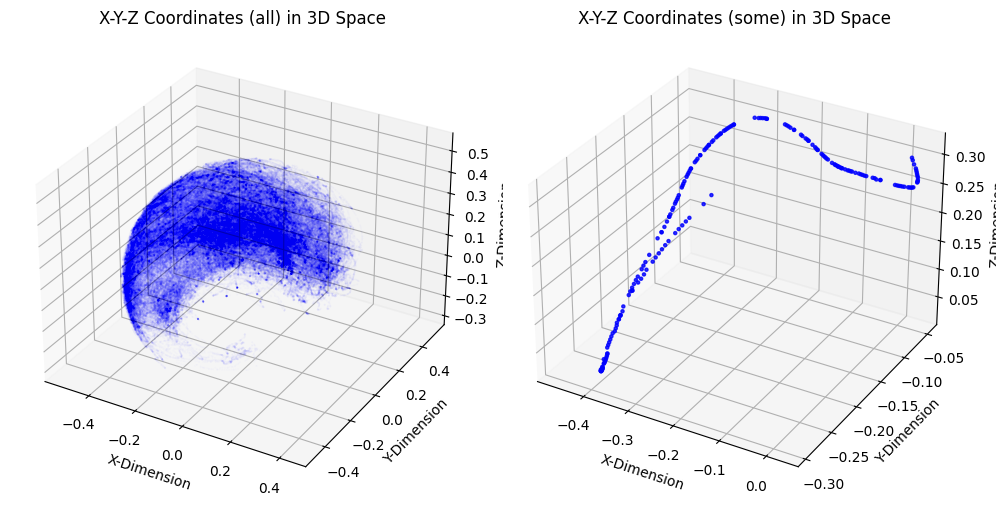

In [4]:
duration = 20       # The duration variable can only have integer values. You may update to visualize different lengths of trajectories
output_visualization(data_raw, duration=duration, randomseed=False)

# interactive_output_visualization(data_raw)    # Uncomment this to view the entire X,Y,Z coordinates in the dataset
interactive_output_visualization(data_raw, duration=duration, randomseed=False)

You can observe here that the raw data's distribution is almost centered around 0. This aids in assessing that the dataset adheres to certain statistical distributions. Can you notice some deviations and outliers in these graphs?

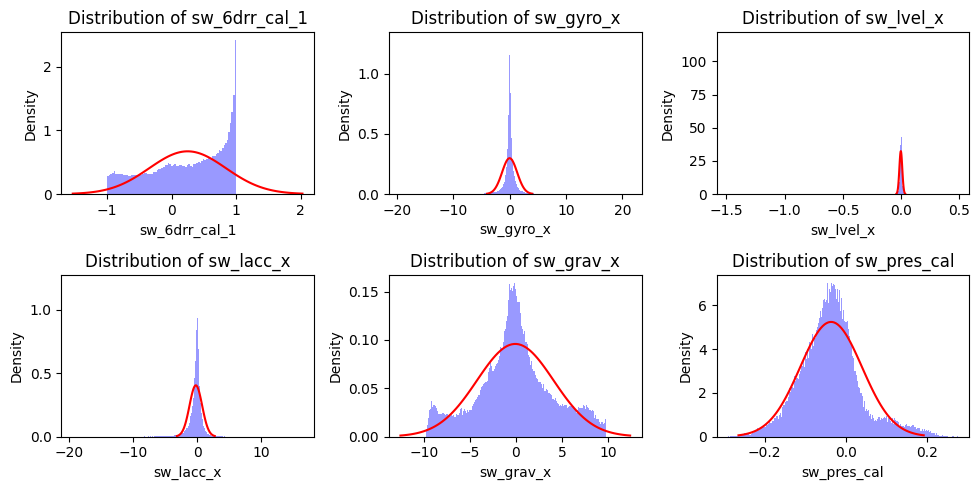

In [5]:
distributionPlot(data_raw)

The following correlation graphs indicate that there might be a close linkage between pressure and ground truth hand origin (relative to the upper arm) Y. 
Conversely, we can notice that there seems to be no linkage at all between the smart watch's gravity and linear acceleration in the x directions. 

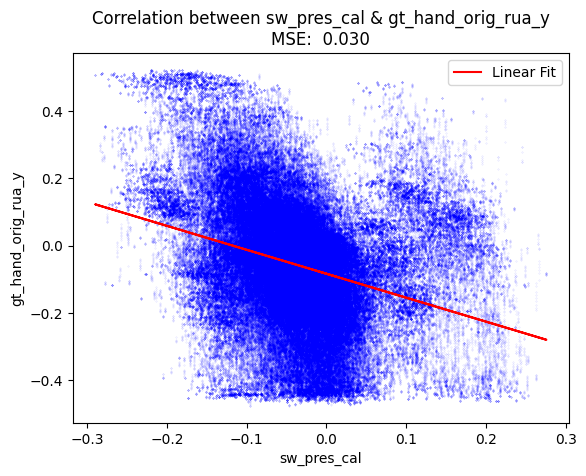

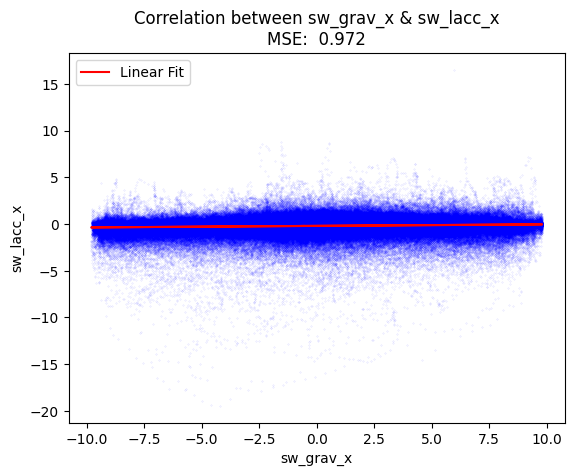

In [6]:
correlationPlot(data_raw)
correlationPlot(data_raw, label1="sw_grav_x", label2="sw_lacc_x")

### 5. Normalization

This part normalizes the data and locally stores it together with means and standard deviations for future use. We normalize by subtracting the mean and dividing by the standard deviation. This newly transformed data is going to be of use in the next script, so we save it locally. 

In the end of this section, we check the data distribution plots of the normalized data and investigate the difference to distribution plots of the raw data files.

In [8]:
gt_columns = [
    "gt_hand_orig_rua_x", "gt_hand_orig_rua_y", "gt_hand_orig_rua_z",
    "gt_larm_6drr_rh_1", "gt_larm_6drr_rh_2", "gt_larm_6drr_rh_3",
    "gt_larm_6drr_rh_4", "gt_larm_6drr_rh_5", "gt_larm_6drr_rh_6",
    "gt_larm_orig_rua_x", "gt_larm_orig_rua_y", "gt_larm_orig_rua_z",
    "gt_uarm_6drr_rh_1", "gt_uarm_6drr_rh_2", "gt_uarm_6drr_rh_3",
    "gt_uarm_6drr_rh_4", "gt_uarm_6drr_rh_5", "gt_uarm_6drr_rh_6"
]

sw_columns = [
    "sw_dt",
    "sw_gyro_x", "sw_gyro_y", "sw_gyro_z",
    "sw_lvel_x", "sw_lvel_y", "sw_lvel_z",
    "sw_lacc_x", "sw_lacc_y", "sw_lacc_z",
    "sw_grav_x", "sw_grav_y", "sw_grav_z",
    "sw_6drr_cal_1", "sw_6drr_cal_2", "sw_6drr_cal_3",
    "sw_6drr_cal_4", "sw_6drr_cal_5", "sw_6drr_cal_6",
    "sw_pres_cal"
]

# filter the columns of interest from the raw data file
data_raw_cs = data_raw.loc[:, gt_columns + sw_columns]

# get means and std of every column
raw_means = data_raw_cs.mean()
raw_stds = data_raw_cs.std()

# we normalize by subtracting the mean and dividing by the std
normalized_data = (data_raw_cs - raw_means) / raw_stds

# combine mean and std into one DataFrame
means_stds_df = pd.concat([raw_means, raw_stds], axis=1)

# create the cache directory if it doesn't exist yet
cache_path = config.paths["cache_path"]
if not cache_path.exists():
    cache_path.mkdir(parents=True)

# store normalized data as well as created means and stds for later use during training and testing
normalized_data.to_csv(cache_path / 'normalized_data.csv', index=False)
means_stds_df.to_csv(cache_path / 'means_stds.csv', index_label='Column')
print(f"Stored normalized data to: {cache_path}")

Stored normalized data to: /Users/affanbinusman/Dropbox (ASU)/IRL-Lab/P&G/p_and_g_hackathon/scripts/cache


Now, you have normalized the data and stored it into the cache directory in your project root. Let us have a look at the distribution plots again. The scales of the data should have changed and distinct data columns should now be in similar value ranges.

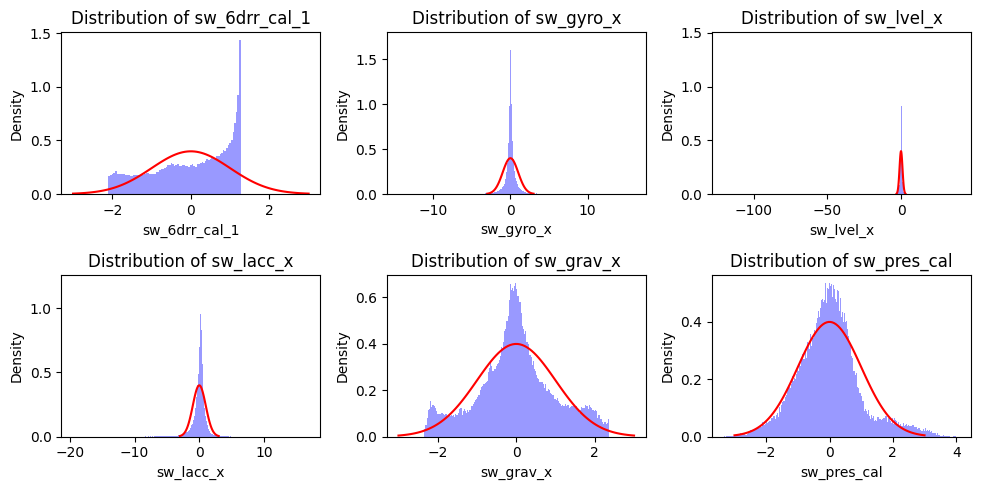

In [10]:
distributionPlot(normalized_data)

Testing - Dataset issues // For Fabian

In [ ]:
distributionPlot(data_raw, ["sw_lvel_x", "sw_lvel_y", "sw_lvel_z","sw_lacc_x", "sw_lacc_y", "sw_lacc_z"])

In [ ]:
data_raw[["sw_lvel_x", "sw_lvel_y", "sw_lvel_z","sw_lacc_x", "sw_lacc_y", "sw_lacc_z"]].describe()

In [ ]:
import pandas as pd
import os

def find_min_max_row_numbers(file_path, columns):
    min_max_info = []

    csv_files = [f for f in os.listdir(file_path) if f.endswith('.csv')]

    for file_name in csv_files:
        file_path_name = os.path.join(file_path, file_name)
        df = pd.read_csv(file_path_name)

        for column in columns:
            min_row = df[column].idxmin()
            min_val = df[column].min()
            max_row = df[column].idxmax()
            max_val = df[column].max()
            min_max_info.append(("".join(file_name.split("_")[-2:]), column, min_row, min_val, max_row, max_val))

    min_max_df = pd.DataFrame(min_max_info, columns=['File Name', 'Attribute', 'Min Row Number', 'Min Value', 'Max Row Number', 'Max Value'])
    return min_max_df

folder_path = config.paths["data_path"]
columns_to_analyze = ["sw_lvel_x", "sw_lvel_y", "sw_lvel_z", "sw_lacc_x", "sw_lacc_y", "sw_lacc_z"]

result_df = find_min_max_row_numbers(folder_path, columns_to_analyze)


In [ ]:
distributionPlot(normalized_data, ["sw_lvel_x", "sw_lvel_y", "sw_lvel_z","sw_lacc_x", "sw_lacc_y", "sw_lacc_z"])

In [ ]:
normalized_data[["sw_lvel_x", "sw_lvel_y", "sw_lvel_z","sw_lacc_x", "sw_lacc_y", "sw_lacc_z"]].describe()